# Description

MangaGO is a project for professional and volunteer manga translators, allowing them to translate Japanese scans automatically. Text detection, retrieval, translation and replacement are fully automated processes. Once the translation is complete, the translator can validate or correct it.

This notebook aims to demonstrate the MangaGO solution in a concise way, originally developed to autonomously run on AWS.

# Imports

In [1]:
%%capture
!pip install easyocr pytesseract datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

In [2]:
%%capture
!sudo apt install tesseract-ocr

In [3]:
%%capture
!apt-get install tesseract-ocr-jpn

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, MarianMTModel, MarianTokenizer
from PIL import Image, ImageDraw
from google.colab import drive
from collections import deque
from PIL import ImageFont
import pytesseract
import textwrap
import easyocr
import cv2
import os

# Convert image if .webp detected

This part is not mandatory, as it seems that it works fine even on .webp

In [6]:
from pathlib import Path

def convert_webp_to_jpeg_if_needed(file_path):
    if Path(file_path).suffix == '.webp':
      image = Image.open(file_path)
      image = image.convert("RGB")
      jpeg_path = f"{os.path.splitext(file_path)[0]}.jpeg"
      image.save(jpeg_path, "jpeg")
      return jpeg_path
    else:
      return file_path

In [15]:
image_path = convert_webp_to_jpeg_if_needed("promised_neverland_45_21.webp")

# Text and coordinates extraction

In [16]:
def is_close(r1, r2, threshold):
    x1, y1, x2, y2 = r1
    x3, y3, x4, y4 = r2

    return not (x2 < x3 - threshold or x1 > x4 + threshold or y2 < y3 - threshold or y1 > y4 + threshold)

def merge_all_coords(all_coords, threshold=60):
    all_coords = deque(all_coords)
    merged_coords = []

    while all_coords:
        current = all_coords.popleft()
        # Keep the index to potentially remove it later
        index = 0

        for other in all_coords:
            if is_close(current, other, threshold):
                x1, y1, x2, y2 = current
                x3, y3, x4, y4 = other
                # Merge
                current = (min(x1, x3), min(y1, y3), max(x2, x4), max(y2, y4))
                # Remove the merged ones from all_coords
                del all_coords[index]
                all_coords.appendleft(current)
                break
            index += 1
        else:
            # If no merge, add the rectangle to merged_coords
            merged_coords.append(current)

    return merged_coords

In [17]:
reader = easyocr.Reader(['ja'], gpu=False, verbose=False)

In [18]:
def detect_text_zones(image_path):
    image = cv2.imread(image_path)
    result = reader.readtext(image_path, detail=1)
    text_zone_images = []
    text_coords = []
    for item in result:
        coordinates = item[0]
        x_min, y_min = int(coordinates[0][0]), int(coordinates[0][1])
        x_max, y_max = int(coordinates[2][0]), int(coordinates[2][1])
        text_zone_image = image[y_min:y_max, x_min:x_max]

        text_coords.append((x_min, y_min, x_max, y_max))

    text_zones = merge_all_coords(text_coords)
    return text_zones

In [19]:
text_zones = detect_text_zones(image_path)

[([[188, 144], [229, 144], [229, 277], [188, 277]], '豊', 0.004721261613763128), ([[608, 98], [658, 98], [658, 310], [608, 310]], '喜', 0.0018760130950603582), ([[154, 378], [264, 378], [264, 482], [154, 482]], '雛', 0.0005562332946782746), ([[41, 565], [123, 565], [123, 607], [41, 607]], '夢巻ざ', 0.00026190418089653834), ([[90, 584], [114, 584], [114, 622], [90, 622]], 'お', 0.044502820498113715), ([[582, 788], [634, 788], [634, 852], [582, 852]], '慧', 0.009207101666763862), ([[629, 789], [665, 789], [665, 833], [629, 833]], '響', 0.02287510350288713), ([[582, 828], [608, 828], [608, 870], [582, 870]], '発', 0.11522498853737151), ([[630, 826], [654, 826], [654, 868], [630, 868]], 'ち', 0.20404401128937266), ([[659, 847], [681, 847], [681, 867], [659, 867]], 'つ', 0.30764516159302957), ([[350, 946], [420, 946], [420, 978], [350, 978]], '【荒な', 0.005961625371128321), ([[388, 972], [420, 972], [420, 1002], [388, 1002]], 'ぜ', 0.9996045026895359), ([[304, 940], [400, 940], [400, 1060], [304, 1060]], 

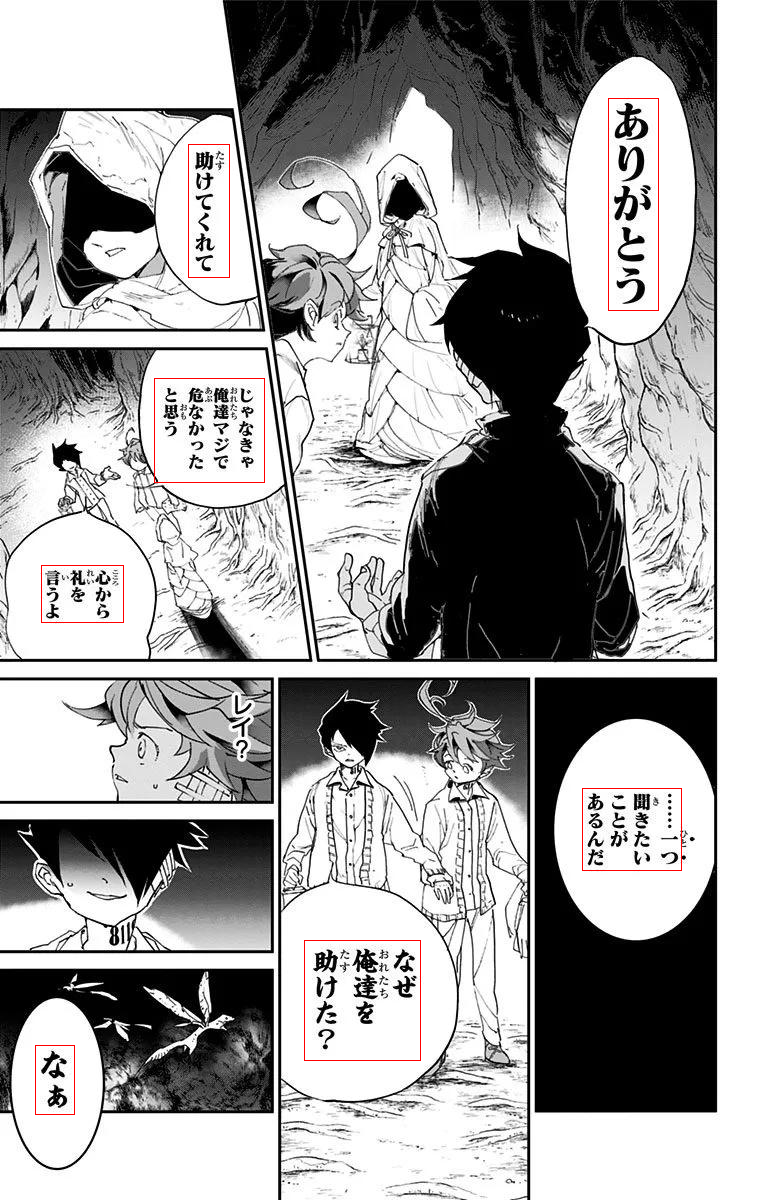

In [20]:
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

for box in text_zones:
  draw.rounded_rectangle(box, outline ='red')

image.show()

In [21]:
pytesseract.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' )
!which tesseract

/usr/bin/tesseract


In [22]:
print(pytesseract.get_languages(config=''))

['eng', 'jpn', 'osd']


In [23]:
extracted_texts = []
for i, text_zone in enumerate(text_zones):
    x_min, y_min, x_max, y_max = text_zone

    image = cv2.imread(image_path)
    text_zone_image = image[y_min:y_max, x_min:x_max]

    gray_image = cv2.cvtColor(text_zone_image, cv2.COLOR_BGR2GRAY)
    _, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    extracted_text = pytesseract.image_to_string(cv2.cvtColor(threshold_image, cv2.COLOR_GRAY2RGB), config='-l jpn --oem 3 --psm 6')
    extracted_text = extracted_text.replace('\n', '')
    extracted_texts.append(extracted_text)

In [24]:
extracted_texts = [t.strip() for t in extracted_texts]
extracted_texts

['助けてくれて',
 'ありがとウフ',
 'と 危4揚しじ蝶理うかマなっジきたでやい',
 '間"礼0うをかよ 。 ら',
 'あこ聞* :るとどき:んがた一だ いつ',
 '動$まなけ 達*ぜた を?',
 '人']

# Text traduction

In [26]:
# You can store finetuned models in your drive and load it afterwards
drive.mount('/content/drive/')

Mounted at /content/drive/


In [27]:
# Instead of MarianMT you can use AutoTokenizer and AutoModelForSeq2SeqLM to load your finetuned model
# model_name = '/content/drive/MyDrive/models/model'
model_name = "Helsinki-NLP/opus-mt-ja-fr"
tokenizer = MarianMTModel.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Text remplacement

In [36]:
def fit_text_to_box(draw, position, text, font_path, max_width, max_height):
    font_size = max_width // 3
    font = ImageFont.truetype(font_path, font_size)

    # Calculate the average character width and maximum characters per line
    avg_char_width = sum(font.getlength(char) for char in text) / len(text)
    max_chars_per_line = max(1, int(max_width / avg_char_width))
    max_lines = max(1, int(max_height / (font.getlength(text))))

    # Wrap the text based on the maximum characters per line
    lines = textwrap.wrap(text, width=max_chars_per_line)
    ascent, descent = font.getmetrics()

    # # Adjust the font size until the text fits within the bounding box
    while len(lines) > max_lines:
        font_size -= 1
        font = ImageFont.truetype(font_path, font_size)
        avg_char_width = sum(font.getlength(char) for char in text) / len(text)
        max_chars_per_line = max(1, int(max_width / avg_char_width))
        lines = textwrap.wrap(text, width=max_chars_per_line)
        ascent, descent = font.getmetrics()
        text_height = font.getmask(text).getbbox()[3] + descent
        max_lines = max(1, int(max_height / text_height))

    y = position[1]
    for line in lines:
        line_height = font.getmask(line).getbbox()[3] + descent
        draw.text((position[0], y), line, font=font, fill="black")
        y += line_height

In [37]:
from transformers import pipeline
pipe = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-ja-fr")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [38]:
def process_whole_scan(path, original_texts, boxes):
    filename = path.split("/")[-1]
    name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    # Some characters such as (€, £, ç, æ, œ) are not handled by the animeace2 font
    font_path = "/content/drive/MyDrive/ESGI/5IABD/PA/font/animeace2_reg.ttf"
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)
    text_padding = 0

    image = Image.open(path)
    draw = ImageDraw.Draw(image)

    for idx in range(len(original_texts)):
        text = original_texts[idx]
        coordinates = boxes[idx]

        # translated_generation = model.generate(**tokenizer(text, return_tensors="pt", padding=True), repetition_penalty=20.)
        # translated_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_generation]

        translated_text = pipe(text)

        text_width = coordinates[2] - coordinates[0] - 2 * text_padding
        text_height = coordinates[3] - coordinates[1] - 2 * text_padding

        draw.rounded_rectangle([(coordinates[0], coordinates[1]), (coordinates[2], coordinates[3])], fill="#ffffff", radius=8)
        fit_text_to_box(draw, (coordinates[0] + text_padding, coordinates[1] + text_padding), translated_text[0]['generated_text'],
                        font_path, text_width, text_height)

    image.save(f"{name}_translated.{extension}")
    image.show()

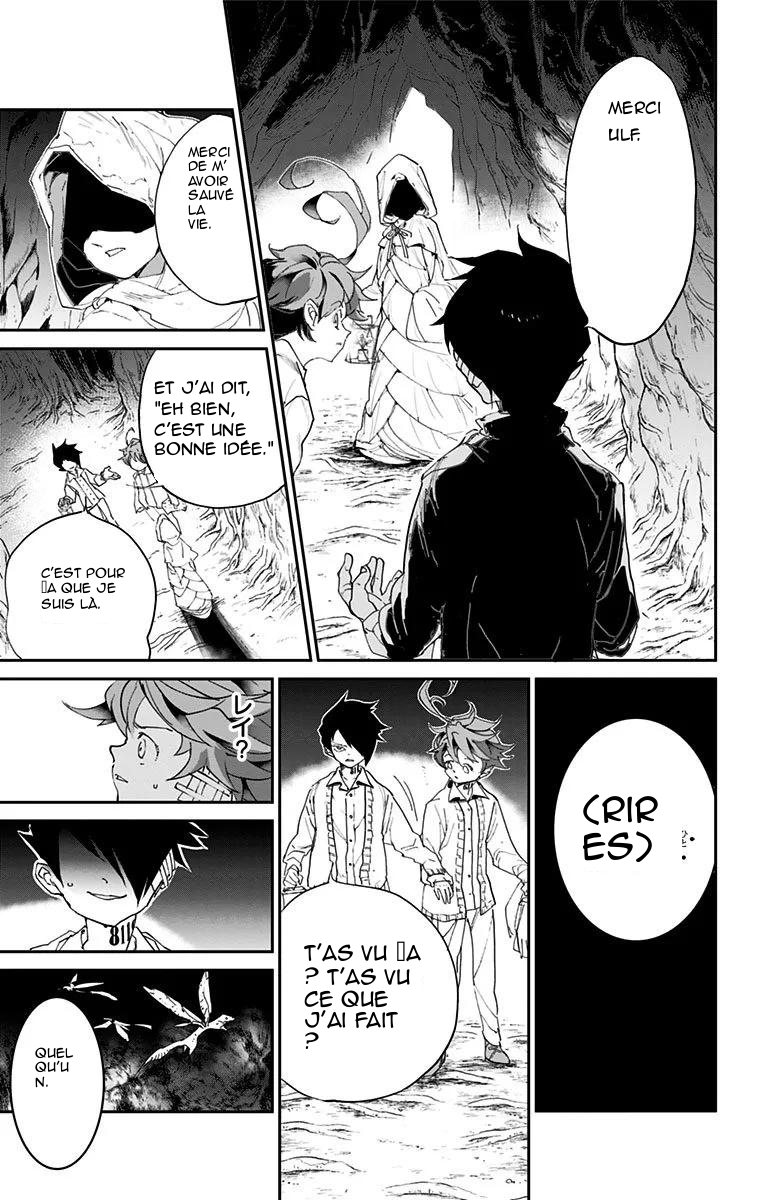

In [39]:
process_whole_scan(image_path, extracted_texts, text_zones)